In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import numpy as np
import scipy.signal

import scipy.signal
from PIL import Image, ImageDraw
#%matplotlib notebook
%matplotlib inline
mpl.rcParams['figure.figsize'] = (18, 6)
cmap =[]

In [2]:
import os, glob, sys


c = np.loadtxt("csv/c18-06-24-12_00.csv",skiprows=1,usecols=(0,1,2,3,4),delimiter=",")
#c = np.loadtxt("c18-07-01-12_00.csv",skiprows=1,usecols=(0,1,2,3,4),delimiter=",")
print(c.shape)
print "done"

(74288L, 5L)
done


(74288L,)
[[3.35581731e-05 3.35581731e-05 3.35581731e-05]
 [3.35581731e-05 3.35581731e-05 3.35581731e-05]
 [3.35581731e-05 3.35581731e-05 3.35581731e-05]
 ...
 [3.35581731e-05 3.35581731e-05 3.35581731e-05]
 [3.35581731e-05 3.35581731e-05 3.35581731e-05]
 [3.35581731e-05 3.35581731e-05 3.35581731e-05]]


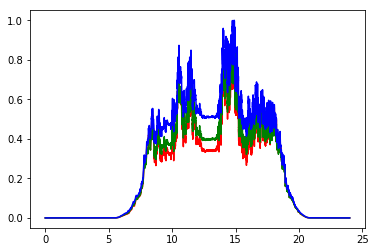

In [3]:
time = c[:,0]
time = (time - time[0])/3600

cmean = np.mean(c[:,1:4],axis=1)
print cmean.shape

#plt.plot(time,c[:,1] -cmean,'r')
#plt.plot(time,c[:,2] - cmean ,'g')
#plt.plot(time,c[:,3]- cmean,'b')

#plt.plot(time,cmean,'k')
#plt.savefig("graph.png")

normc = c[:,1:4]/np.max(c[:,1:4])
plt.plot(time,normc[:,0],'r')
plt.plot(time,normc[:,1],'g')
plt.plot(time,normc[:,2],'b')

print normc

In [4]:

from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = ListedColormap(normc, name='skycolor', N=None)

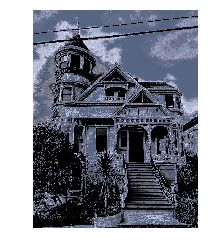

<Figure size 432x288 with 0 Axes>

In [6]:
from PIL import Image

fname = 'stoch.png'
image = Image.open(fname).convert("L")
arr = np.asarray(image)
plt.imshow(arr, cmap=cmap)
plt.axis('off')  
plt.show()
plt.savefig("stoch-skycolor.png")

In [7]:
# create include file
def rgb_to_hex(r, g, b):
    hc = int(b*255)
    hc = hc + (int(g*255) << 8)
    hc = hc + (int(r*255) << 16)
    return "0x{:x}".format(hc)


red = np.array(c[:,1]) - 1
grn = np.array(c[:,2]) - 1
blu = np.array(c[:,3]) - 1


mmax = np.max([np.max(red), np.max(blu), np.max(grn)])

redf = red/mmax
grnf = grn/mmax
bluf = blu/mmax

cinc = open("colors.h",'w')

cinc.write("const PROGMEM prog_uint32_t ctable[]={")
# skip beginning zeros

skipbegin = True
hexcolors =[]
carray =[]
skipcount =0
for i, r in enumerate(red):

    if (red[i]+grn[i]+blu[i]) == 0 and skipbegin:
        skipcount += 1
    else:
        skipbegin = False
        if (red[i]+grn[i]+blu[i]) > 0 :
            hexcolors.append(rgb_to_hex(redf[i],grnf[i],bluf[i]))
            carray.append([redf[i],grnf[i],bluf[i]])
    
for hc in hexcolors[:-1]:
    cinc.write("{:s},\n".format(hc) )
cinc.write("{:s}}};\n".format(hc) )

            
cinc.write("\n#define SKIP_BEGIN {:d}\n".format(skipcount) )
cinc.write("\n#define CTAB_LEN {:d}\n".format(i) )
cinc.write("#define SECS_PER_C {:f}\n".format((24*3600.)/i) )
cinc.close()

print("{} zero colors skipped".format(skipcount))

579 zero colors skipped


In [8]:
with open('skycolors.csv', 'w+') as f:
    for i, r in enumerate(red):
        f.write("{:f},{:f},{:f}\n".format(red[i],grn[i],blu[i]))

    

saved frame000.png
saved


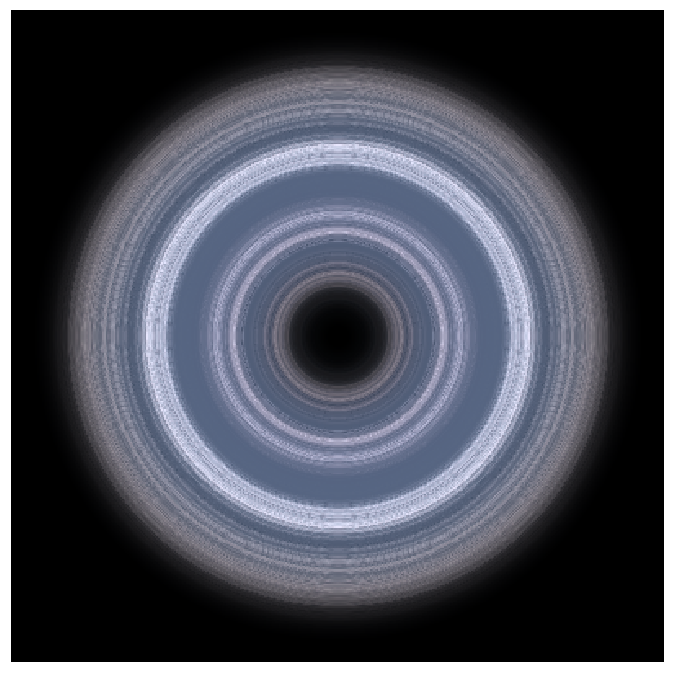

In [9]:
# radial plot
import imageio
def getcolor(cmap, frac):
    """ go fraction into cmap and return a color triple """
    l, w = cmap.shape
    assert(w ==3)
    i = int(l*frac)
    if i >= l:
        i = l-1
    if i < 0:
        i = 0
    return cmap[i,:]
    

width = 400
height = 400
out = np.zeros((width,height,3),dtype=float)

offset =[0.]
carray = np.array(carray)
for i, off in enumerate(offset):
    for w in range(width):
        for h in range(height):

            x = (w - width/2)/float(width) 
            y = (h - height/2)/float(height)
            r = np.sqrt(x*x + y*y)
            #th = np.arctan2(y,x)
            #day = int(100*th*4/2*np.pi)
            # want to show morning, so outside (max) is zero and inside (min) is 1/2
            out[h,w] = getcolor(carray, 2*r)
        
        
    
    fname  = "frame{:03d}.png".format(i)
    imageio.imwrite(fname, (255*out).astype(np.uint8))
    print "saved " + fname
    if i ==0 :
        fig = plt.figure(frameon=False, figsize = (12,12))
        plt.imshow(out)
        plt.axis('off')  
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        #plt.savefig('advance{:03d}.png'.format(i),bbox_inches='tight', pad_inches=0)
        print "saved"
    # to convert to gif with imagemagick
    #$ /cygdrive/c/Program\ Files/ImageMagick-7.0.5-Q16/convert.exe   -delay 7 -loop 0 frame*.png ani.gif
#ffmpeg -r 15 -f image2  -i frame%03d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p  test.mp4


saved


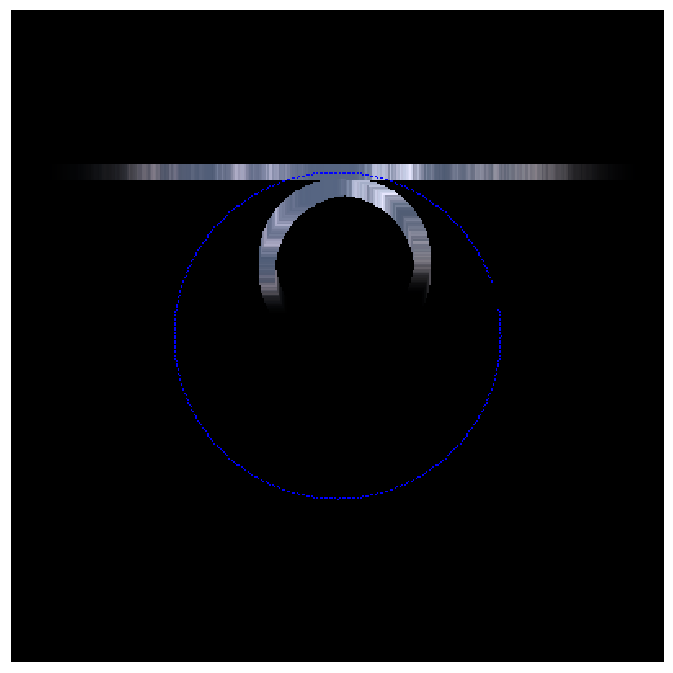

In [10]:
# circle inversion cf http://mathworld.wolfram.com/Inversion.html

def getcolor(cmap, frac):
    """ go fraction into cmap and return a color triple """
    l, w = cmap.shape
    assert(w ==3)
    i = int(l*frac)
    if i >= l:
        i = l-1
    if i < 0:
        i = 0
    return cmap[i,:]
    

width = 400
height = 400

cx = 200
cy = 200
k = 100

block = 10
out = np.zeros((width,height,3),dtype=float)

y = 95
for x  in range(width-block):
    # draw circle
    phi = 2*np.pi*float(x-block)/float(width)
    out[int(k*np.sin(phi)+ cx),int(k*np.cos(phi)+ cy)] = [0., 0., 1.]
    
    for b in range(block):
        for c in range(block):
            out[y+c, x+b] = getcolor(carray, float(x-block)/float(width))
            xx = cx + k*k*(x - cx)/((x - cx)*(x- cx) + (y -cy)*(y-cy)) +c
            yy = cy + k*k*(y - cy)/((x - cx)*(x- cx) + (y -cy)*(y-cy)) +b 
            if xx >= width:
                xx = width -1
            if yy >= height:
                yy = height -1
            out[yy,xx] = getcolor(carray, float(x)/float(width))


fig = plt.figure(frameon=False, figsize = (12,12))
plt.imshow(out)
plt.axis('off')  
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
        #plt.savefig('advance{:03d}.png'.format(i),bbox_inches='tight', pad_inches=0)
print "saved"
    # to convert to gif with imagemagick
    #$ /cygdrive/c/Program\ Files/ImageMagick-7.0.5-Q16/convert.exe   -delay 7 -loop 0 frame*.png ani.gif
#ffmpeg -r 15 -f image2  -i frame%03d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p  test.mp4


saved


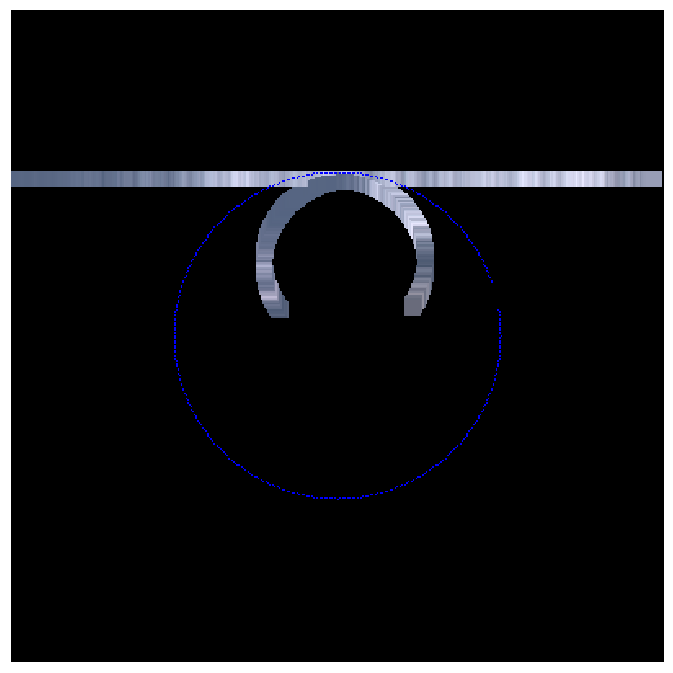

In [11]:
# circle inversion cf http://mathworld.wolfram.com/Inversion.html

def getcolor_frac(cmap, frac, fstart, frange):
    """ go fraction into cmap and return a color triple """
    l, w = cmap.shape
    assert(w ==3)

    # map frac [0->1] into [start->start+frange]
    frac = frac*frange + fstart
    i = int(l*frac)
    if i >= l:
        i = l-1
    if i < 0:
        i = 0
    return cmap[i,:]
    

width = 400
height = 400

cx = 200
cy = 200
k = 100

block = 10
out = np.zeros((width,height,3),dtype=float)

y = 99
for x  in range(width-block):
    # draw circle
    phi = 2*np.pi*float(x-block)/float(width)
    out[int(k*np.sin(phi)+ cx),int(k*np.cos(phi)+ cy)] = [0., 0., 1.]
    
    for b in range(block):
        for c in range(block):
            out[y+c, x+b] = getcolor_frac(carray, float(x-block)/float(width),0.5, 0.1)
            #out[y+c, x+b] = (128,128,128)
            xx = cx + k*k*(x - cx)/((x - cx)*(x- cx) + (y -cy)*(y-cy)) +c
            yy = cy + k*k*(y - cy)/((x - cx)*(x- cx) + (y -cy)*(y-cy)) +b 
            if xx >= width:
                xx = width -1
            if yy >= height:
                yy = height -1
            out[yy,xx] = getcolor_frac(carray, float(x)/float(width),0.25,0.5)


fig = plt.figure(frameon=False, figsize = (12,12))
plt.imshow(out)
plt.axis('off')  
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
        #plt.savefig('advance{:03d}.png'.format(i),bbox_inches='tight', pad_inches=0)
print "saved"
    # to convert to gif with imagemagick
    #$ /cygdrive/c/Program\ Files/ImageMagick-7.0.5-Q16/convert.exe   -delay 7 -loop 0 frame*.png ani.gif
#ffmpeg -r 15 -f image2  -i frame%03d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p  test.mp4


done


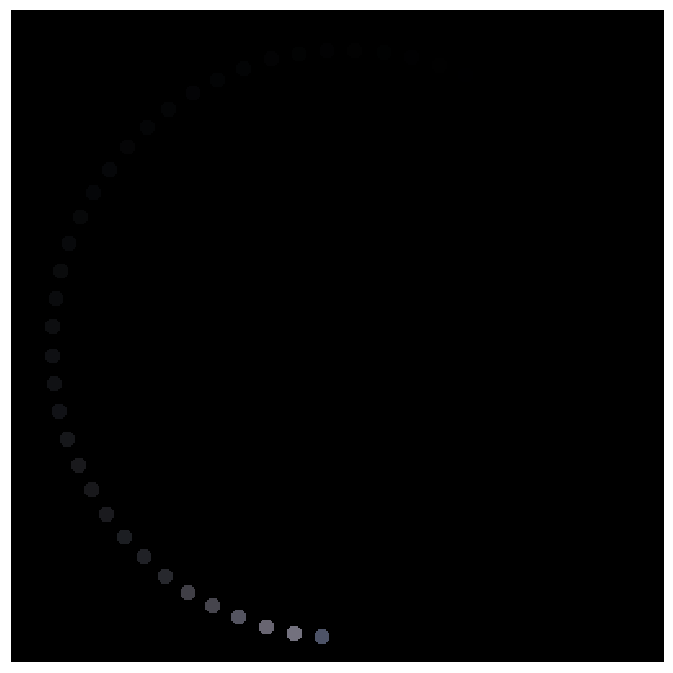

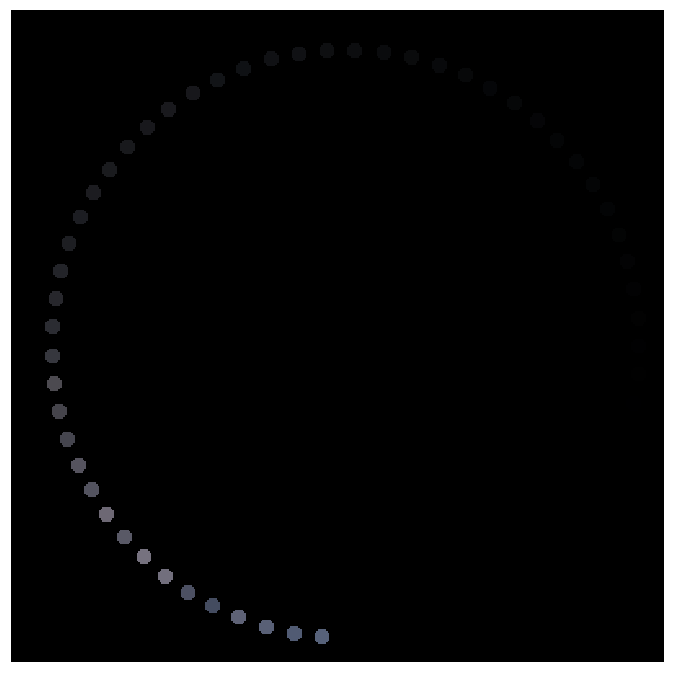

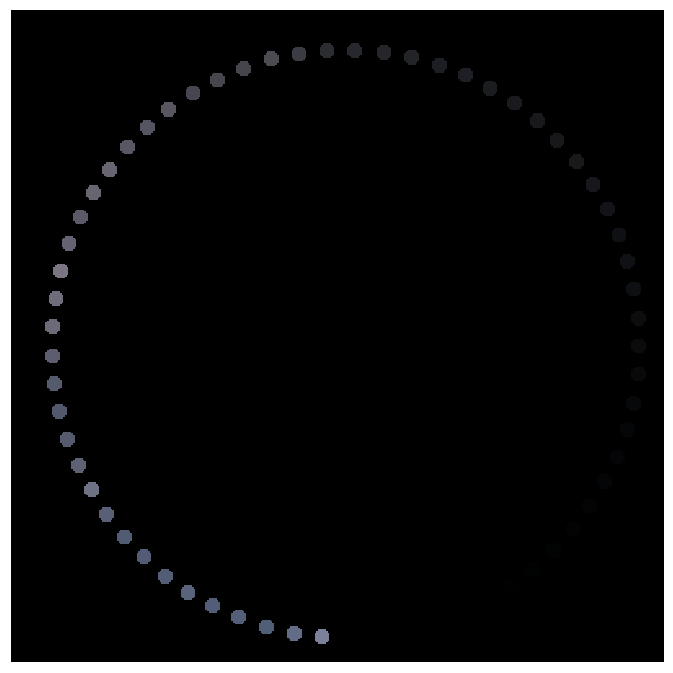

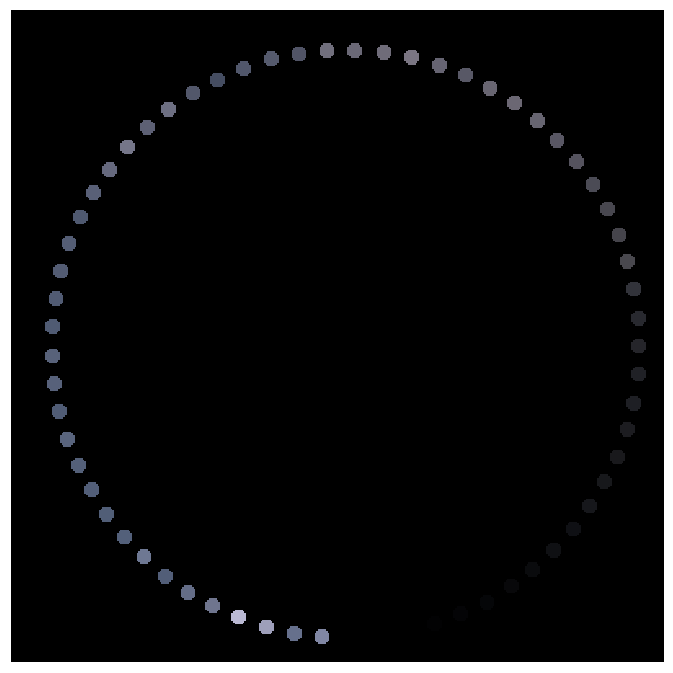

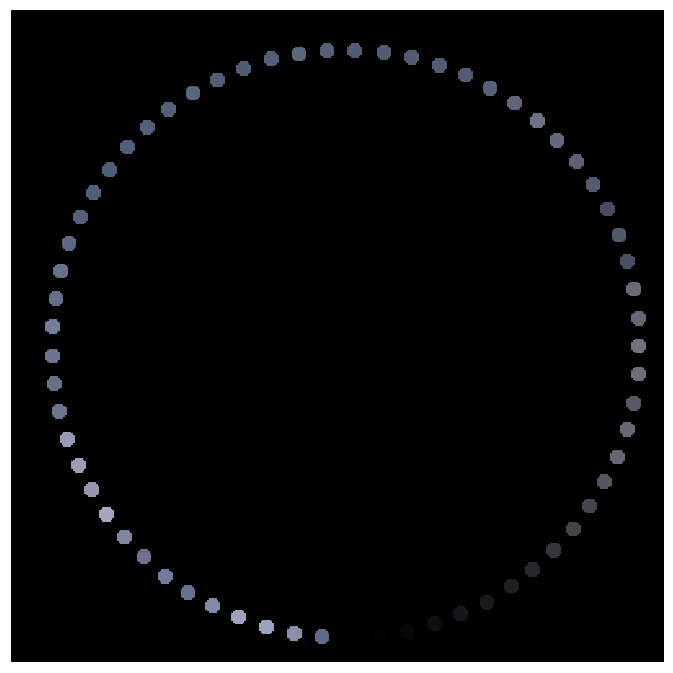

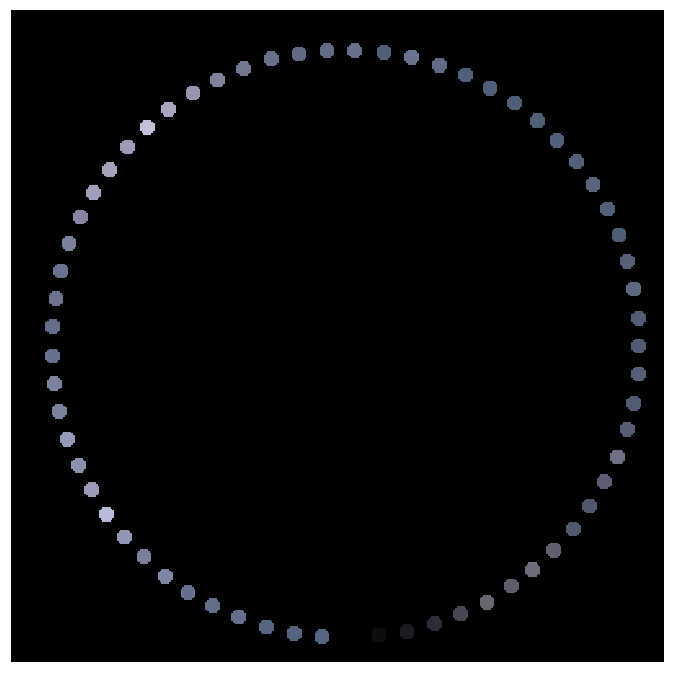

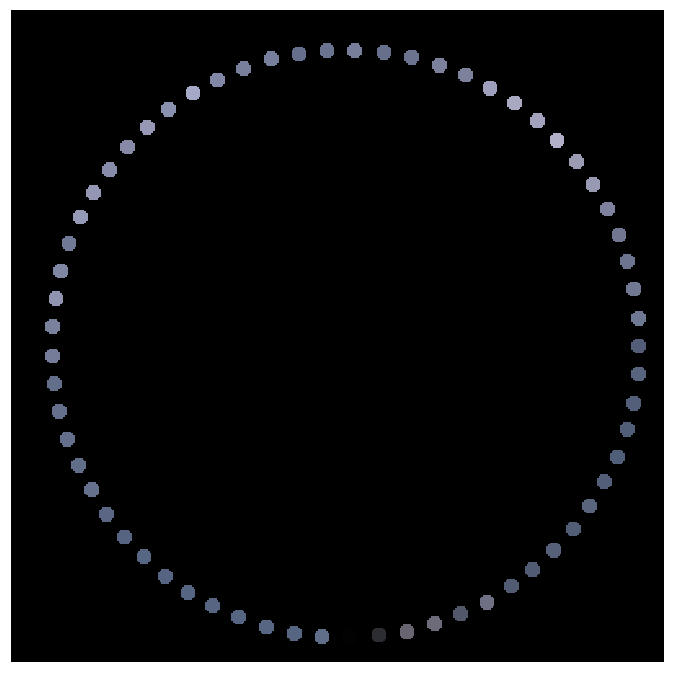

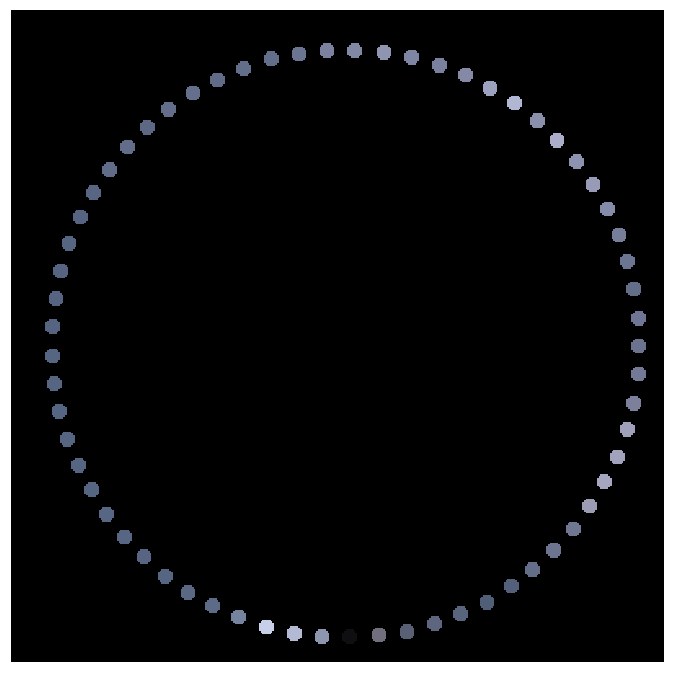

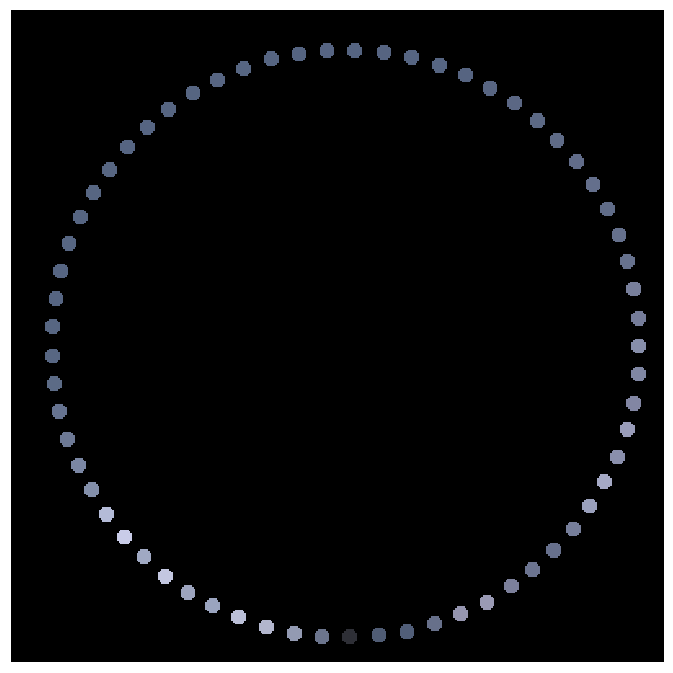

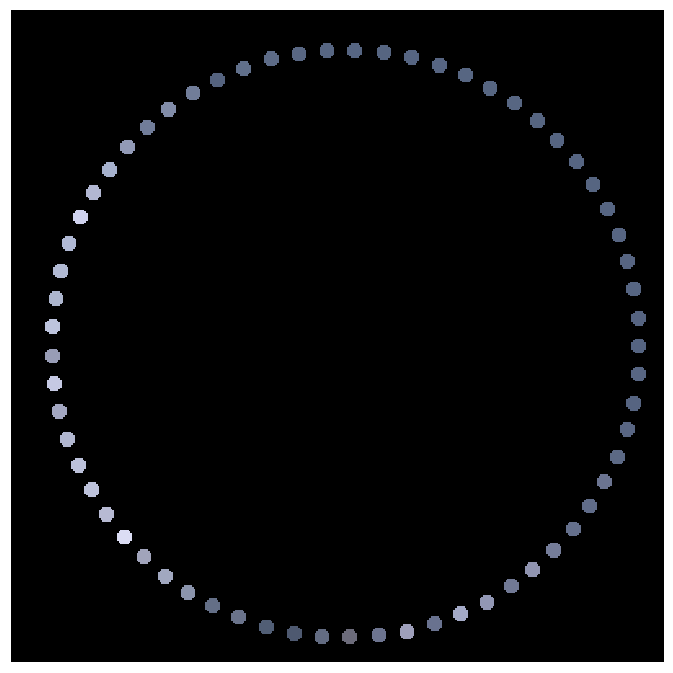

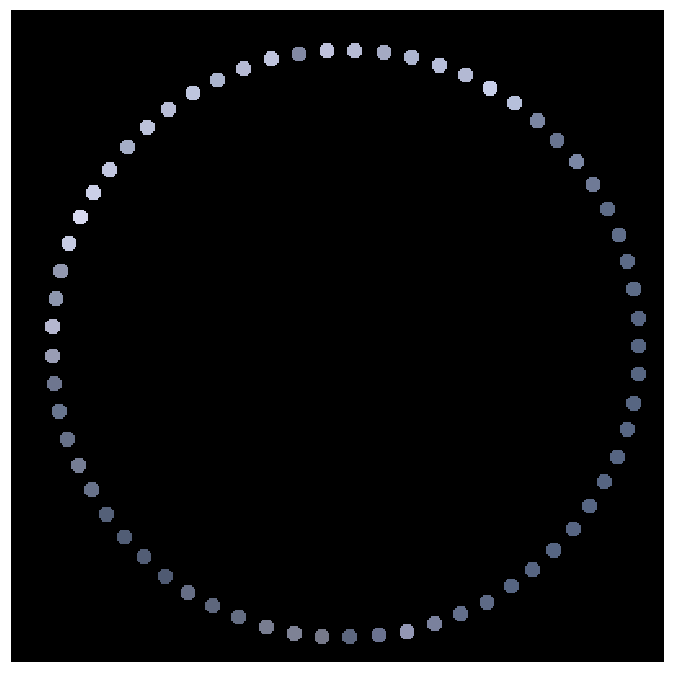

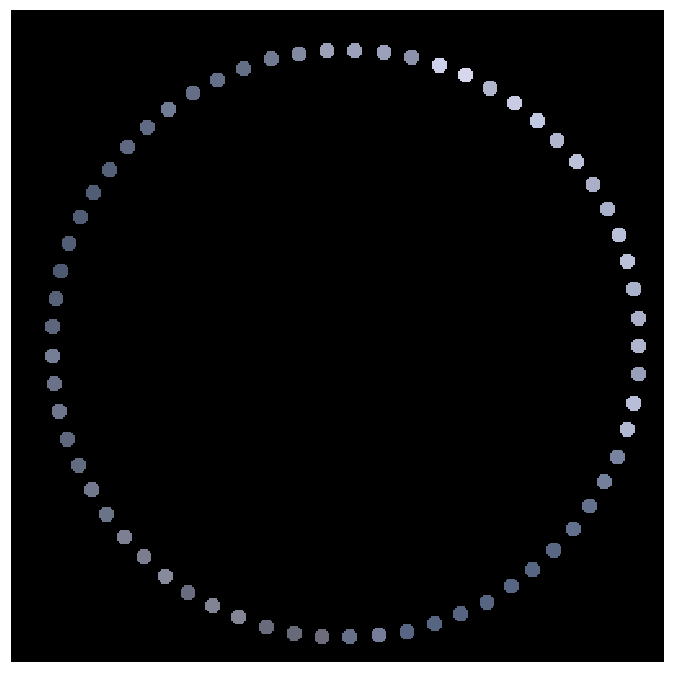

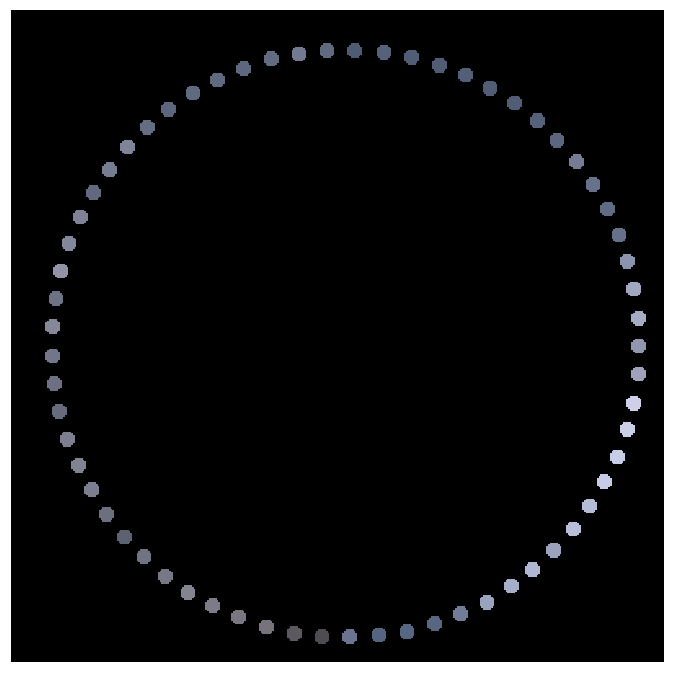

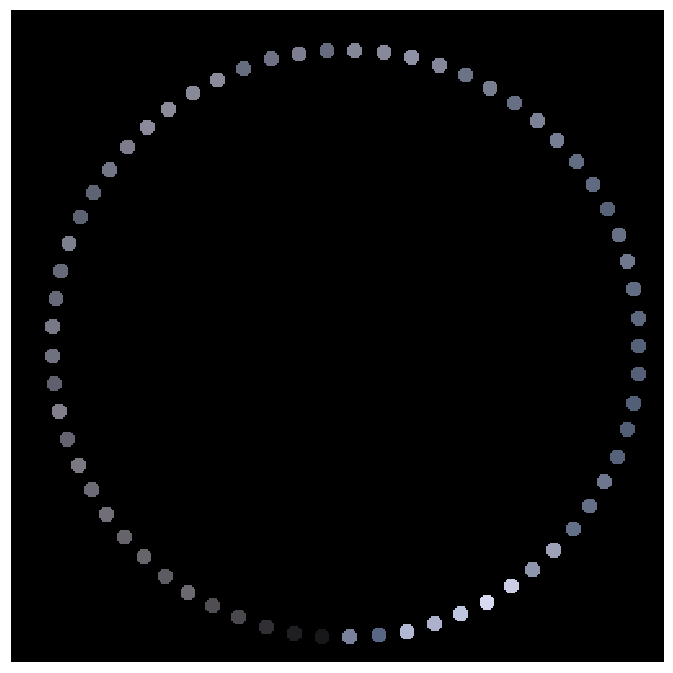

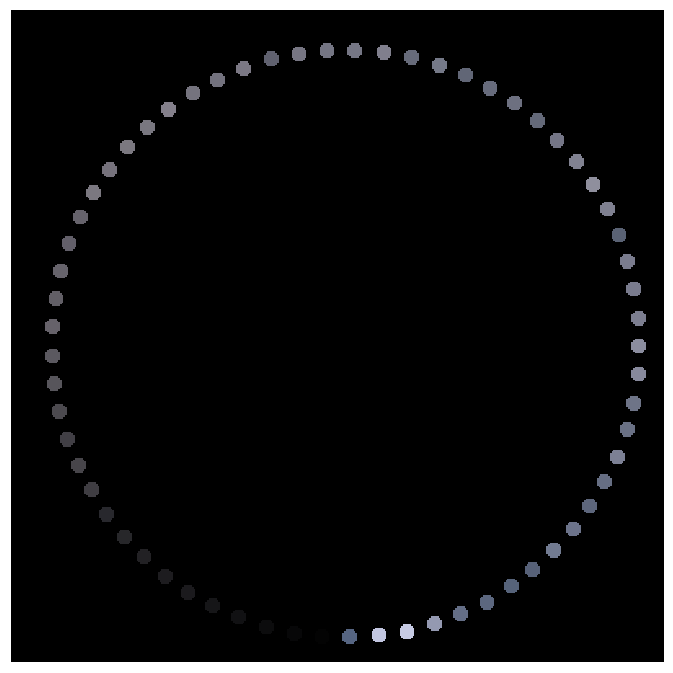

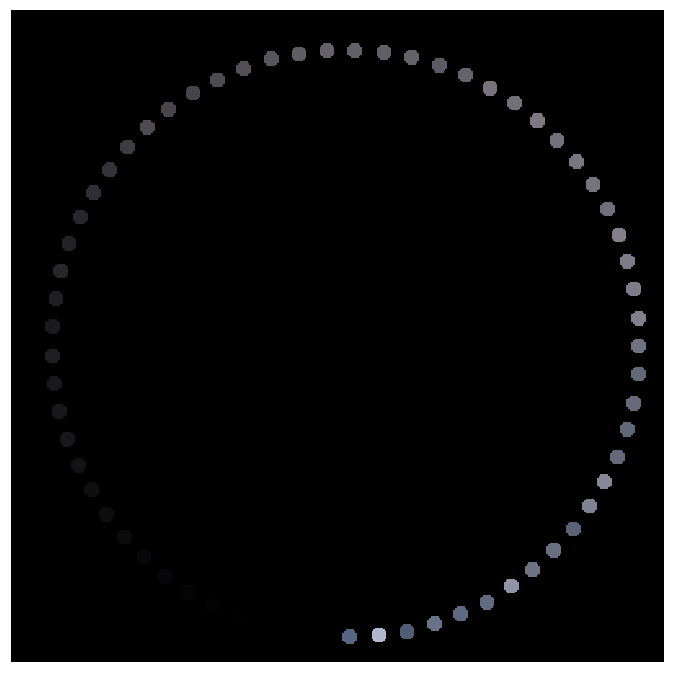

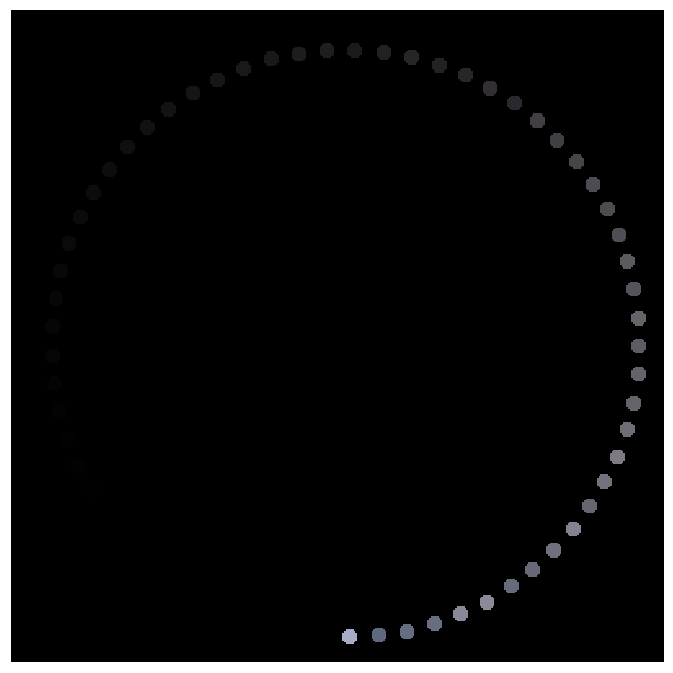

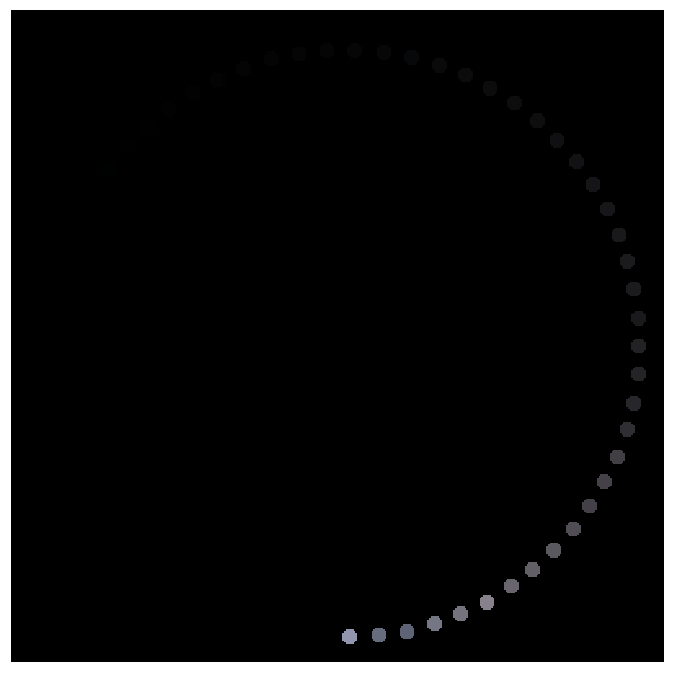

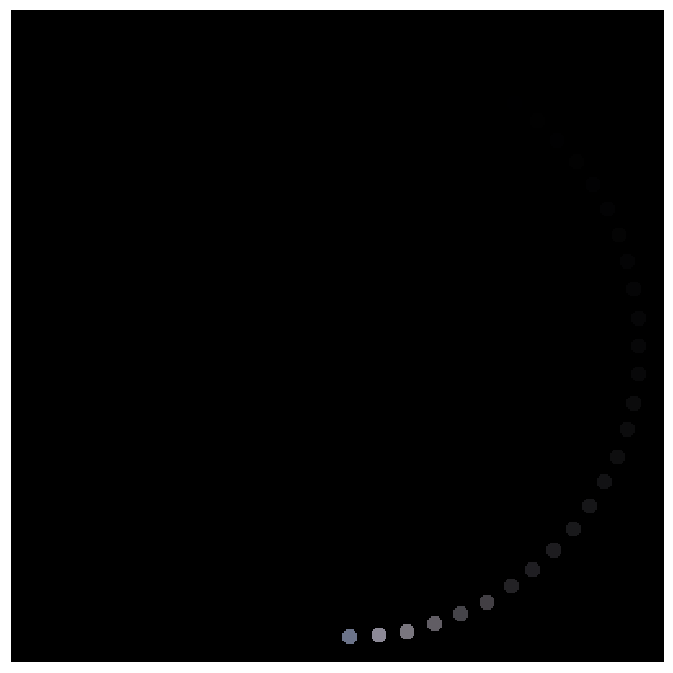

In [26]:
# circle mapping 

def getcolor_frac(cmap, frac, fstart, frange):
    """ go fraction into cmap and return a color triple """
    l, w = cmap.shape
    assert(w ==3)

    # map frac [0->1] into [start->start+frange]
    frac = frac*frange + fstart
    i = int(l*frac)
    if i >= l:
        i = l-1
    if i < 0:
        i = 0
    return cmap[i,:]

def pmap(x, inmin, inmax, outmin, outmax):
    # processing-like map function
    # first map to 0-1
    y = (x -inmin)/(inmax-inmin)
    return(y*(outmax-outmin) + outmin)

def hyp_map(i, n,hcent,zoom):
    '''hyperbolic map: returns int i 0<i<n  where i is hyperbolically mapped with center at fraction c 0.< c <1.
    and zoomed'''
    x = zoom*((float(i)/n - 0.5) + (0.5 - hcent) )
    y = (np.exp(2*x) -1)/(np.exp(2*x) +1 )
    # y is now -1<0<1

    return int((y+1)*n/2.)

def ihyp_map(o, n, m, hcent, zoom):
    '''i is output element out of n.  
       m is total number of input slots'''
    eps = 0.001
    x = 2*(o/float(n))  - 1.0
    if x <= -1.0:
        x = -1.0 + eps
    elif x >= 1.0:
        x = 1.0 - eps
    
    y = 2*np.log((1 +x)/(1-x) )
    # y is now symmetric around zero, recenter, scale to m, and clip
    m = float(m)
    i = (zoom*0.5*m*y) + hcent*m 
    if i >= m:
        i = m 
    elif i < 0:
        i = 0

    return i


# hyperbolically map
def getcolor_hyp(cmap, frac, hcent, zoom):
    """ go fraction into cmap and return a color triple """
    l, w = cmap.shape
    assert(w ==3)

    j = int(frac*l)
    # map frac [0->1] into [start->start+frange]
    i = int(ihyp_map(j, l, l,  hcent, zoom))
    #print j, i, l
    if i >= l:
        i = l-1
    if i < 0:
        i = 0
    return cmap[i,:]
    

width = 400
height = 400

centx = 200
centy = 200
k = 180


block = 10
b2 = block/2
out = np.zeros((width,height,3),dtype=float)


y = 99
nframes=20
for off in range(1,nframes):
    for x  in range(1,width-block, 6):
    # draw circle
        phi = 2*np.pi*float(x)/float(width -block)
        cx = int(k*np.sin(phi)+ centx) 
        cy = int(k*np.cos(phi)+ centy)
        ccolor = getcolor_hyp(carray, float(x)/float(width), off/float(nframes), 0.05)
        for b in range(-b2,b2):
            for c in range(-b2, b2):
                if np.sqrt(b*b + c*c) < b2:
                    out[cy+c+b2, cx+b+b2] = ccolor

    fig = plt.figure(frameon=False, figsize = (12,12))
    plt.imshow(out)
    plt.axis('off')  
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.savefig('hyp{:03d}.png'.format(off),bbox_inches='tight', pad_inches=0)
print "done"
    # to convert to gif with imagemagick
    #$ /cygdrive/c/Program\ Files/ImageMagick-7.0.5-Q16/convert.exe   -delay 7 -loop 0 frame*.png ani.gif
#ffmpeg -r 15 -f image2  -i frame%03d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p  test.mp4


In [ ]:
# radial plots

def getcolor(cmap, frac):
    """ go fraction into cmap and return a color triple """
    l, w = cmap.shape
    assert(w ==3)
    i = int(l*frac)
    if i >= l:
        i = l-1
    if i < 0:
        i = 0
    return cmap[i,:]
    

width = 1200
height = 1200
out = np.zeros((width,height,3),dtype=float)

for w in range(width):
    for h in range(height):

        x = (w - width/2)/float(width) 
        y = (h - height/2)/float(height)
        r = np.sqrt(x*x + y*y)
        th = np.arctan2(y,x)
        #print x, y, r
        #out[w,h,:] = [0, 0, 0]
        day = int(100*th*8/(2*np.pi))
        # want to show morning, so outside (max) is zero and inside (min) is 1/2
        out[h,w] = getcolor(daysg[day],0.5*(1-r))
        # want to show evening, so outside (max) is 1 and inside (min) is 1/2
        #out[h,w] = getcolor(days[200],1.2*(r + 1)/2)
        #out[h,w] = getcolor(days[200],r)
        
        
    

plt.figure(figsize = (12,12))
plt.imshow(out)
plt.axis('off')    
plt.savefig('radial4.png')

In [ ]:
def get_colors_for(c):
    red = c[:,1]
    grn = c[:,2]
    blu = c[:,3]

    mmax = np.max([np.max(red), np.max(blu), np.max(grn)])

    red = red/mmax
    grn = grn/mmax
    blu = blu/mmax


    colors = []
    for i, r in enumerate(red):
        colors.append(mpl.colors.to_rgb((red[i],grn[i],blu[i])))
    return colors

c = get_colors_for(newdata[0])


In [ ]:
newd = np.array(newd)
print newd.shape

In [ ]:


cmap = []
for d in newd[3:4]:
    print d.shape
    colors = d[:,1:4]
    # gamma correct
    colors = (colors / 65535.)**(1/2.2)
    colors = colors/np.max(colors)
    #colors = colors/mmax
    
    print colors.shape
    dcol =  scipy.signal.decimate(colors, 10, n=None, ftype='iir', axis=0, zero_phase=True)
    dcol_wide = np.multiply.outer(np.ones((1000)),dcol)
    cmap.extend(dcol_wide)
    
#dcol_wide = np.multiply.outer(np.ones((500)),dcol)
#dcol_wide = np.swapaxes(dcol_wide,1,2)
cmap = np.swapaxes(cmap,0,1)
cmap = np.array(cmap,dtype=float)
#print days.shape

#daysn = days/np.max(days)

#plt.imshow(cmap[1500:7500,:])
fig = plt.figure(frameon=False, figsize = (12,12))
plt.imshow(cmap[1500:7500,:])
plt.axis('off')  
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
plt.savefig('cmap.jpg',bbox_inches='tight', pad_inches=0)

In [1]:
   fig = plt.figure(frameon=False, figsize = (12,12))
    plt.imshow(out)
    plt.axis('off')  
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.savefig('advance{:03d}.png'.format(i),bbox_inches='tight', pad_inches=0)

IndentationError: unexpected indent (<ipython-input-1-a88060bec5b0>, line 2)